# Spectral Counting (SpC) Analysis with R and edgeR

## Phil Wilmarth, OHSU

### October 1, 2018

The data is from the ABRF iPRG 2015 study and is described in (Choi-2017). Six proteins were prepared in 4 different abundance mixes and spiked into a yeast cell lysate background. Each of the 4 different spike-in experiments were analyzed in triplicate on a Q-Exactive instrument. Each sample was analyzed using a single LC run. It is not clear from the publication if the triplicate runs are technical replicates or biological replicates.

The RAW files were downloaded along with a yeast FASTA file. RAW files were converted to MS2 files using MSConvert (Kessner-2008; Chambers-2012) and scripts that are part of the [PAW pipeline](https://github.com/pwilmart/PAW_pipeline.git) (Wilmarth-2009). Comet (Eng-2013) searches used a wide parent ion mass tolerance (Hsieh-2009) to maximize the number of peptide identifications using the target/decoy (Elias-2007) validation method. Other parameters were trypsin cleavage, M+16 variable mod, C+57 static mod, and a 1.0005 Da fragment ion tolerance (better setting for a QE should have been used). Accurate peptide delta masses (differences between theoretical and measured masses) were used to create conditional score histograms and filter peptide matches to 1% FDR.

The Yeast FASTA file available with the RAW files has the sequences for the 6 spike-in proteins hidden amongst the yeast proteins. Six random yeast proteins had their sequences changed to those of the spike in proteins, but the accessions and descriptions were not altered. I added the 6 spike-in sequences to the database along with common contaminants and created an appropriate target/decoy database using utilities from [this repository](https://github.com/pwilmart/fasta_utilities.git).

Protein inference followed the basic parsimony logic rules and was applied experiment-wide (using data from all 12 samples). Protein identification required two peptides per protein per sample in at least one sample experiment-wide to make the final list. 

The goal here is to demonstrate some R and edgeR (Robinson-2010) statistical testing that can be used for spectral counting (Liu-2004) semi-quantitative experiments. The PAW pipeline has some features for shotgun quantitation that we will be using. One is a protein grouping algorithm where highly homologous proteins (majority of peptides are shared with few unique peptides) are grouped together and the context for shared or unique peptides are updated accordingly. This extended parsimony logic is described in more detail [here](https://digitalcollections.ohsu.edu/concern/etds/c534fp149). The other feature is the splitting of shared peptide spectral counts based on relative unique peptide evidence.

EdgeR has been used in some other spectral counting experiments I have been involved with. The Fei et al. 2011 study had smaller replicate numbers and batch effects. Smith et. al. 2018 was a large (over 5 million MS2 spectra) paired study design. I may do a notebook for the later study to demonstrate paired study designs.

> Chambers, M.C., Maclean, B., Burke, R., Amodei, D., Ruderman, D.L., Neumann, S., Gatto, L., Fischer, B., Pratt, B., Egertson, J. and Hoff, K., 2012. A cross-platform toolkit for mass spectrometry and proteomics. Nature biotechnology, 30(10), p.918.

> Choi, M., Eren-Dogu, Z.F., Colangelo, C., Cottrell, J., Hoopmann, M.R., Kapp, E.A., Kim, S., Lam, H., Neubert, T.A., Palmblad, M. and Phinney, B.S., 2017. ABRF Proteome Informatics Research Group (iPRG) 2015 Study: Detection of Differentially Abundant Proteins in Label-Free Quantitative LC–MS/MS Experiments. Journal of proteome research, 16(2), pp.945-957.

> Elias, J.E. and Gygi, S.P., 2007. Target-decoy search strategy for increased confidence in large-scale protein identifications by mass spectrometry. Nature methods, 4(3), p.207.

> Eng, J.K., Jahan, T.A. and Hoopmann, M.R., 2013. Comet: an open‐source MS/MS sequence database search tool. Proteomics, 13(1), pp.22-24.

> Fei, S.S., Wilmarth, P.A., Hitzemann, R.J., McWeeney, S.K., Belknap, J.K. and David, L.L., 2011. Protein database and quantitative analysis considerations when integrating genetics and proteomics to compare mouse strains. Journal of proteome research, 10(7), pp.2905-2912.

> Hsieh, E.J., Hoopmann, M.R., MacLean, B. and MacCoss, M.J., 2009. Comparison of database search strategies for high precursor mass accuracy MS/MS data. Journal of proteome research, 9(2), pp.1138-1143.

> Kessner, D., Chambers, M., Burke, R., Agus, D. and Mallick, P., 2008. ProteoWizard: open source software for rapid proteomics tools development. Bioinformatics, 24(21), pp.2534-2536.

> Liu, H., Sadygov, R.G. and Yates, J.R., 2004. A model for random sampling and estimation of relative protein abundance in shotgun proteomics. Analytical chemistry, 76(14), pp.4193-4201.

> Robinson, M.D., McCarthy, D.J. and Smyth, G.K., 2010. edgeR: a Bioconductor package for differential expression analysis of digital gene expression data. Bioinformatics, 26(1), pp.139-140.

> Smith JR, David LL, Appukuttan B, Wilmarth PA. Angiogenic and Immunologic Proteins Identified by Deep Proteomic Profiling of Human Retinal and Choroidal Vascular Endothelial Cells: Potential Targets for New Biologic Drugs. Am J Ophthalmol. 2018 Sep;193:197-229. doi: 10.1016/j.ajo.2018.03.020. Epub 2018 Mar17. PubMed PMID: 29559410; PubMed Central PMCID: PMC6109601.

> Wilmarth, P.A., Riviere, M.A. and David, L.L., 2009. Techniques for accurate protein identification in shotgun proteomic studies of human, mouse, bovine, and chicken lenses. Journal of ocular biology, diseases, and informatics, 2(4), pp.223-234.

---

## Load libraries

In [1]:
library(edgeR)
library(limma)
library(tidyverse)
library(psych)
library(RColorBrewer)

Warning message:
“package ‘edgeR’ was built under R version 3.5.2”Loading required package: limma
Warning message:
“package ‘limma’ was built under R version 3.5.1”── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.3.0
✔ tibble  2.0.1     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.3.1     ✔ forcats 0.3.0
Warning message:
“package ‘tibble’ was built under R version 3.5.2”── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
“package ‘psych’ was built under R version 3.5.2”
Attaching package: ‘psych’

The following objects are masked from ‘package:ggplot2’:

    %+%, alpha



## Some dataset and search information
There were 12 LC runs on a QE that generated 383,054 MS2 scans. The Comet/PAW pipeline is sensitive, and 238,365 scans passed accurate mass and score thresholds. There were 2,489 REVERSED PSMs for an FDR of 1.04%. The overall MS2 identification rate was 62%. The PSMs mapped to a final protein list of 2879 proteins (50 REVERSED) using a requirement of at least two peptides per protein per sample in at least one sample experiment-wide.

## Do the data cleaning and prep using R
We will start with the text summary file produced by the protein grouping script. That has some extra lines above the main table and some additional lines after the table. We can take care of the top lines during file reading. We will use some dplyr (tidyverse) techniques for filtering rows, etc. We need to drop the trailing lines, and double check what has been automatically tagged as common contaminants. We need to make sure that the extra BSA sequence has not been put in with the contaminants. We will ignore any proteins with entries in the Filter column (contaminants and reversed).

In [2]:
# try and start with the actual results file and wrangle data
# Summary table has lines before and after that are not strictly in table
# skip the leading lines when loading the table and read in just the table rows
full <- read_tsv("grouped_protein_summary_8.txt", skip = 4,
                 n_max = 2848, guess_max = 2848)

# check what are contaminants (we do not want any EXTRA accessions excluded)
check <- full %>% 
  select(Accession, Description, Filter) %>%
  filter(Filter == "contaminant")
check

Parsed with column specification:
cols(
  .default = col_double(),
  Accession = col_character(),
  Identical = col_character(),
  Similar = col_character(),
  OtherLoci = col_character(),
  Filter = col_character(),
  Coverage = col_character(),
  SeqLength = col_character(),
  MW = col_character(),
  Description = col_character()
)
See spec(...) for full column specifications.


Accession,Description,Filter
CONT_005|Trypa5|PromTArt5,"Promega trypsin artifact 5 K to R mods (2239.1, 2914)(1987, 2003).",contaminant
CONT_010|gi|136429|sp|P00761|TRYP_PIG (+1),TRYPSIN PRECURSOR [Sus scrofa].,contaminant
CONT_018|gi|113580|sp|P02770|ALBU_RAT,SERUM ALBUMIN PRECURSOR [Rattus norvegicus].,contaminant
CONT_046|gi|88041|pir||A31994 (+3),"keratin 10, type I, epidermal [Homo sapiens].",contaminant
CONT_088|gi|1346343|sp|P04264|K2C1_HUMAN,"KERATIN, TYPE II CYTOSKELETAL 1 (CYTOKERATIN 1) (K1) (CK 1) (67 KD CYTOKERATIN) (HAIR ALPHA PROTEIN) [Homo sapiens].",contaminant
CONT_015|gi|229552|prf||754920A_family,'(albumin [Bos primigenius taurus].),contaminant


## Table is ready to prep for spectral counting
We have read in the slightly messy summary file, dropped prefix and suffix lines, and made sure that bovine serum albumin is not being excluded as a contaminant. We will want to do some prep before getting count data for statistical testing. We want a minimum count cutoff to avoid the ragged lower end of the identifications.

We will add a new column that is the average corrected spectral counts and set that to zero for contaminants and decoys. We can also add a count of how many samples had missing data (counts of zero). Then we will sort that table by decreasing average corrected count. We also need a parsed accessions column (no repeat counts in parentheses).

In [3]:
# add the new columns to data frame and sort
full  <-  full %>%
  mutate(acc = sapply(strsplit(Accession, " "), `[`, 1)) %>%
  mutate(ave = ifelse(is.na(Filter), rowMeans(select(., starts_with("Corrected_"))), 0.0)) %>%
  mutate(missing = apply(select(., starts_with("Corrected_")) == 0, 1, sum)) %>%
  arrange(desc(ave))
head(full)
nrow(full)

ProtGroup,Counter,Accession,Identical,Similar,OtherLoci,Filter,Coverage,SeqLength,MW,⋯,Corrected_JD_sample2_C,Corrected_JD_sample3_A,Corrected_JD_sample3_B,Corrected_JD_sample3_C,Corrected_JD_sample4-A,Corrected_JD_sample4_B,Corrected_JD_sample4_C,acc,ave,missing
474,1,sp|P19097|FAS2_YEAST,NA,NA,NA,NA,58.3,1887,206944,⋯,121.000,114.000,114.000,112.000,115.000,124.000,106.000,sp|P19097|FAS2_YEAST,114.08333,0
94,1,sp|P00549|KPYK1_YEAST,NA,NA,"sp|P00549|KPYK1_YEAST, sp|P52489|KPYK2_YEAST",NA,72.8,500,54544,⋯,97.837,94.936,101.806,95.755,90.867,92.903,97.760,sp|P00549|KPYK1_YEAST,96.74858,0
179,1,sp|P06169|PDC1_YEAST,NA,NA,"sp|P06169|PDC1_YEAST, sp|P16467|PDC5_YEAST, sp|P26263|PDC6_YEAST",NA,55.4,563,61495,⋯,99.636,100.235,116.213,108.654,77.471,100.795,91.674,sp|P06169|PDC1_YEAST,94.66042,0
213,1,sp|P07259|PYR1_YEAST,NA,NA,"sp|P03965|CARB_YEAST, sp|P07259|PYR1_YEAST",NA,50,2214,245038,⋯,79.000,84.778,90.000,87.000,93.853,98.000,83.838,sp|P07259|PYR1_YEAST,88.02242,0
201,1,sp|P07149|FAS1_YEAST,NA,NA,NA,NA,48.2,2051,228688,⋯,86.000,81.000,86.000,93.000,83.000,89.000,77.000,sp|P07149|FAS1_YEAST,85.50000,0
107,1,sp|P00925|ENO2_YEAST,NA,NA,"sp|P00924|ENO1_YEAST, sp|P00925|ENO2_YEAST",NA,63.6,437,46914,⋯,84.176,87.943,98.293,91.662,81.014,85.165,79.154,sp|P00925|ENO2_YEAST,84.76150,0


[1] 2848

## Set an appropriate average SpC cutoff
In any shotgun experiment, more things can be identified than can be quantified. For quantification we need data points for all samples. The "bottom" of the dataset will be proteins seen in one or a few samples. We will need to exclude those. How do we identify them? An ad hoc approach is to consider a two-condition experiment. These are often some sort of biomarker experiment so there might be a protein in one condition that is not in the other. A very good rule for protein identification is two peptides per protein. That means that an SpC (spectral count) of 2 is at the detection limit. We want something above that lower limit to define a protein as confidently "present". A value of 5 is a good robust spectral count value; few decoy proteins will ever have an SpC of 5 or greater. If we have 5 counts in one condition and no counts in the other, then an average SpC of 2.5 could be a good cutoff value. Can we use the data itself to set the cutoff?

## Plot number of missing data points versus average SpC

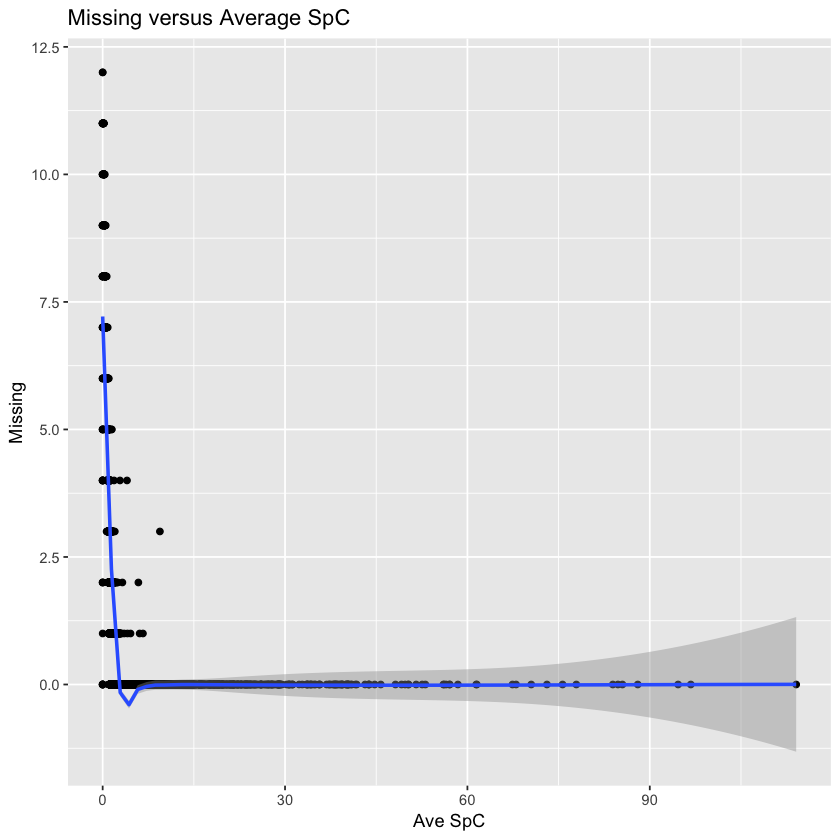

In [4]:
ggplot(full, aes(x = ave, y = missing)) +
  geom_point() + geom_smooth(method = loess) +
  ggtitle("Missing versus Average SpC") + labs( x = "Ave SpC", y = "Missing")

## We have sharp increase in missing data at low average SpC
We need to expand the x-axis to see where the increase starts.

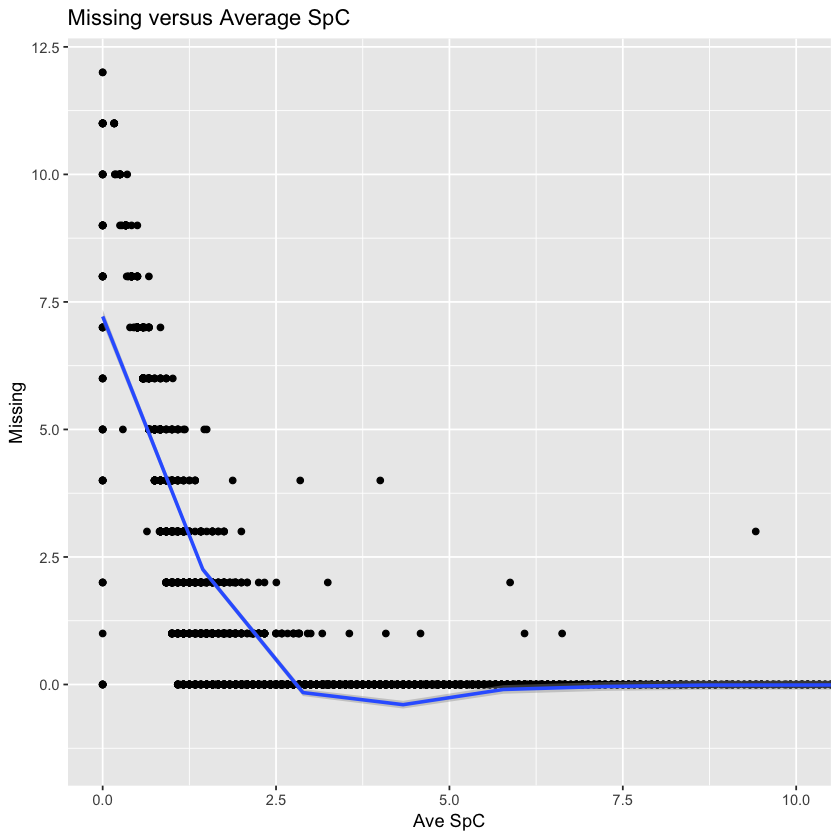

In [5]:
ggplot(full, aes(x = ave, y = missing)) +
  geom_point() + geom_smooth(method = loess) +
  coord_cartesian(xlim = c(0, 10)) +
  ggtitle("Missing versus Average SpC") + labs( x = "Ave SpC", y = "Missing")

## Data indicate an average SpC cutoff of 2.5
The data happens to confirm our intuition about what a good average SpC cutoff might be. We will use an average SpC of 2.5 or greater. That will eliminate most missing data. EdgeR can tolerate a few zero counts, so we will not have to worry about any data imputation.

We need to get the corrected spectral count columns that have an average SpC of 2.5 or greater into a data frame. In any bottom up proteomics study, what to do with shared peptides is an issue. The quantitative information associated with shared peptides is very much less than for unique peptides. The PAW pipeline redefines the status of shared and unique peptides during protein inference. The initial context is with respect to the protein database. Once indistinguishable proteins are grouped and proteins without any independent evidence (subsets) are removed (parsimony), the context becomes the list of identified proteins. The PAW pipeline also has a protein grouping step to combine proteins with highly homologous peptide sets (such as actins, tubulins, etc.). These changing contexts shift many shared peptides to unique peptides. 

There will still be shared peptides. They can be excluded, they can be lumped into the "best" protein that contains them (some definition of "best" is needed in this "all or nothing" strategy), or they can be split into fractional counts based on relative abundance estimates (from the unique counts). The PAW pipeline does the latter. These "corrected" counts will be floating point numbers for some proteins and will need to be rounded to integers.

In [26]:
# get proteins (rows) where average SpC is greater than 2.5
# edgeR will want integer counts so round the corrected counts
counts <- full %>%
  filter(ave >= 2.5) %>%
  select(starts_with("Corrected")) %>%
  round(., 0)
accessions <- full %>%
  filter(ave >= 2.5) %>%
  select(acc)

# create a frame to hold results from edgeR
results <- accessions

## Check within condition (samples 1, 2, 3, or 4) replicates (runs A, B, C)
We will see below that the total counts are similar between runs and the composition is also very similar (it is mostly the yeast proteins) so we do not need to worry about normalizations in order to do some data visualizations. We will check how similar each of the 3 replicates are for the 4 samples (with linear and log plots). The average SpC cutoff of 2.5 eliminates a lot of missing data but there are still some zero counts. EdgeR will not complain about a few zeros. The plotting will complain so we will add one to counts for the log plots.

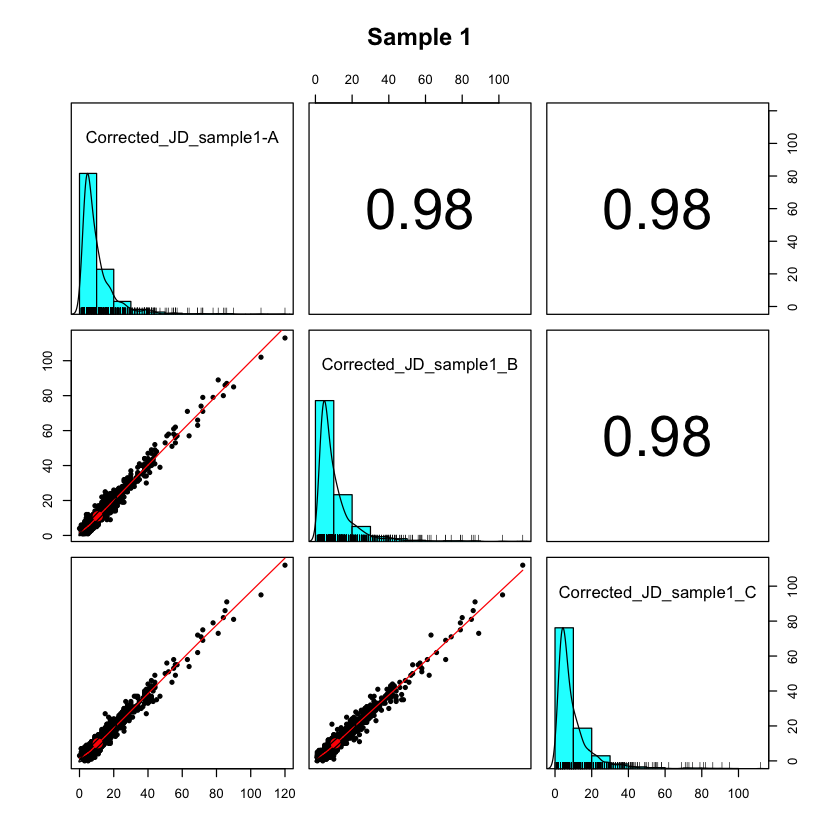

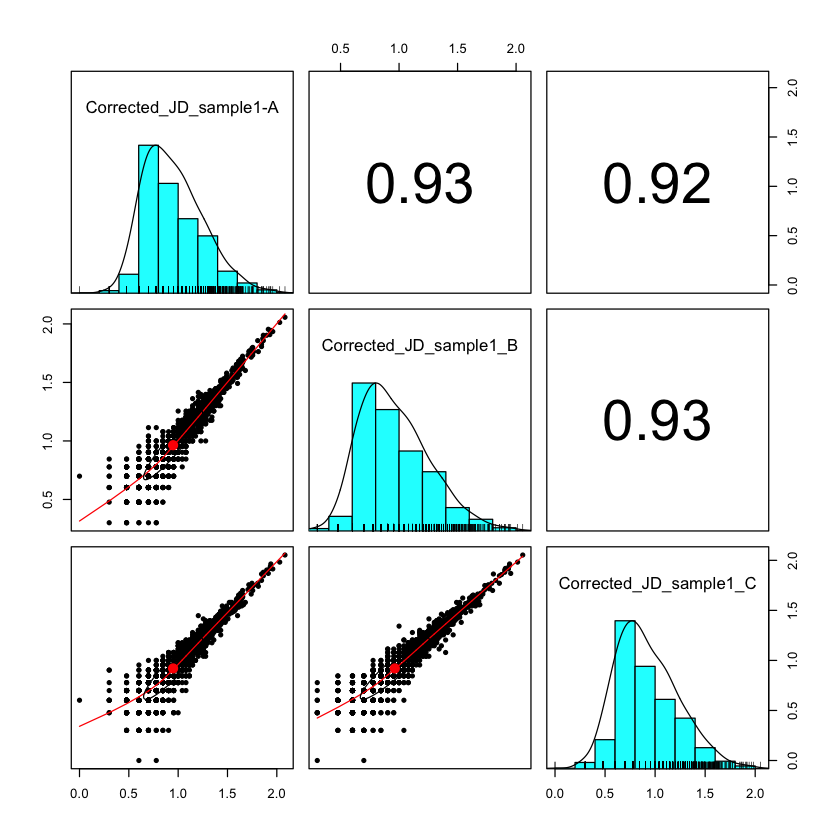

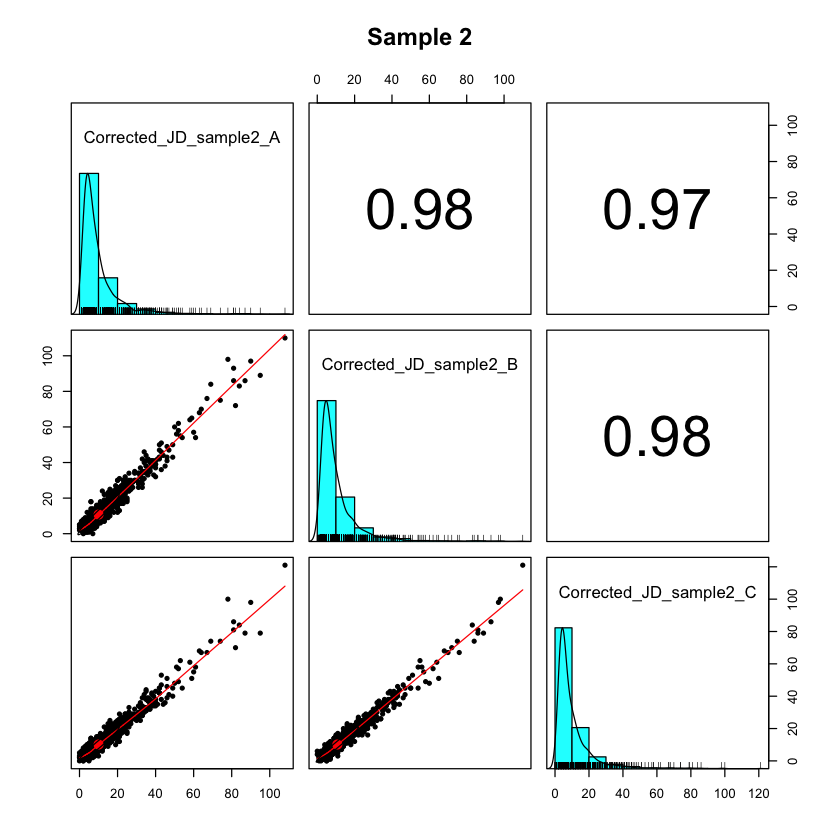

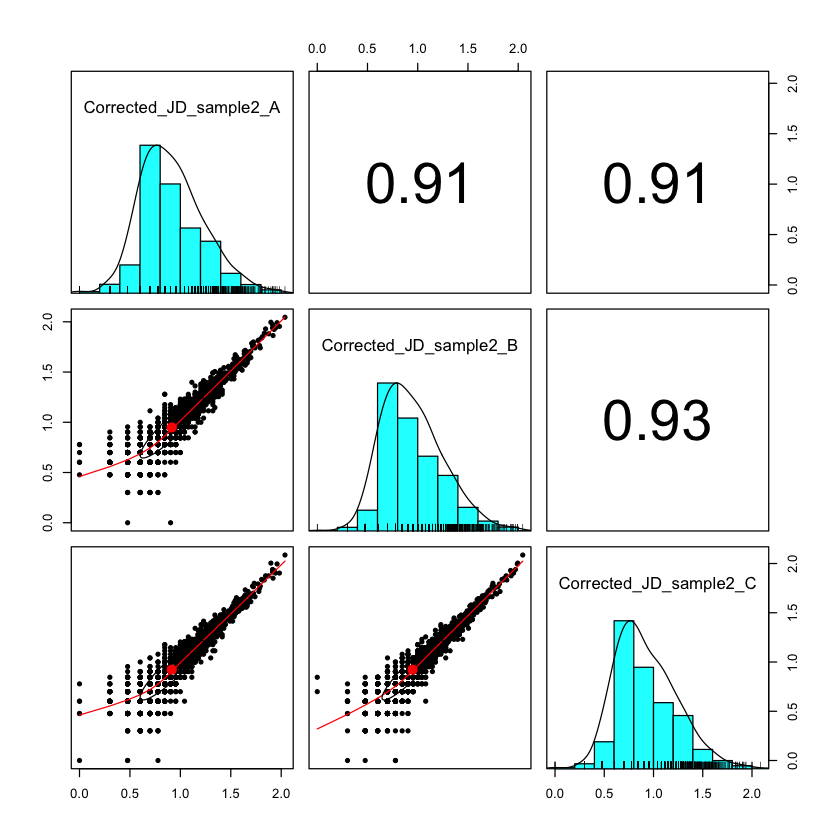

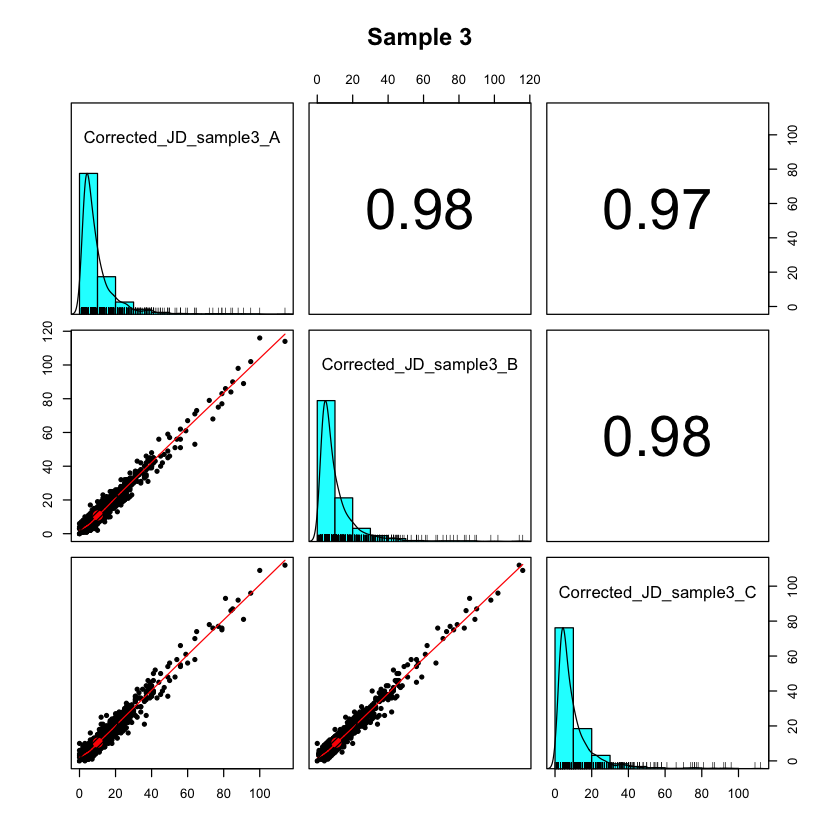

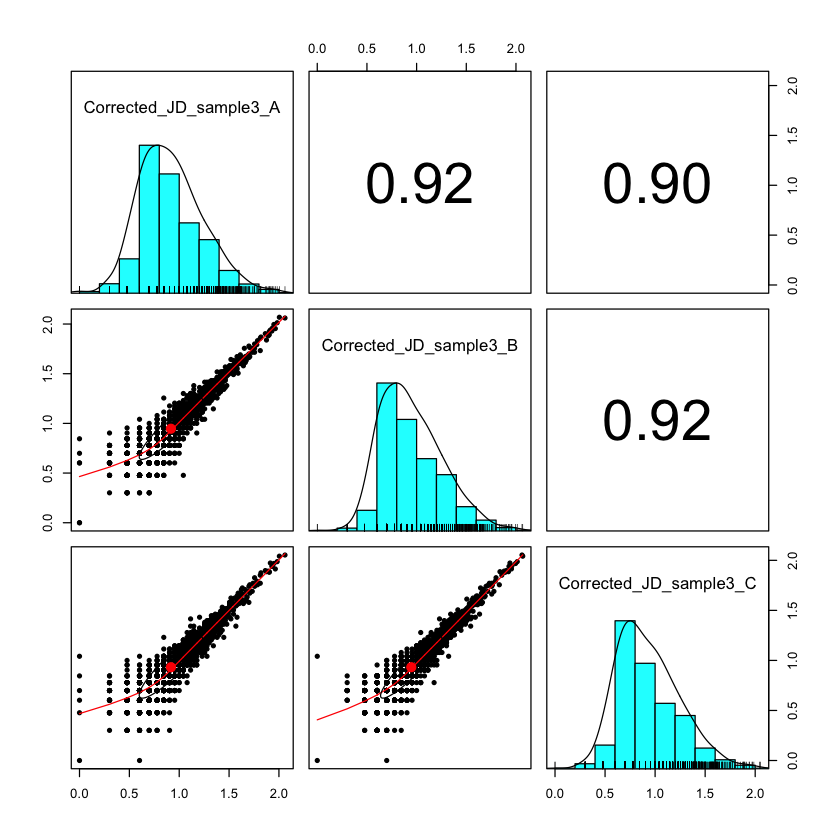

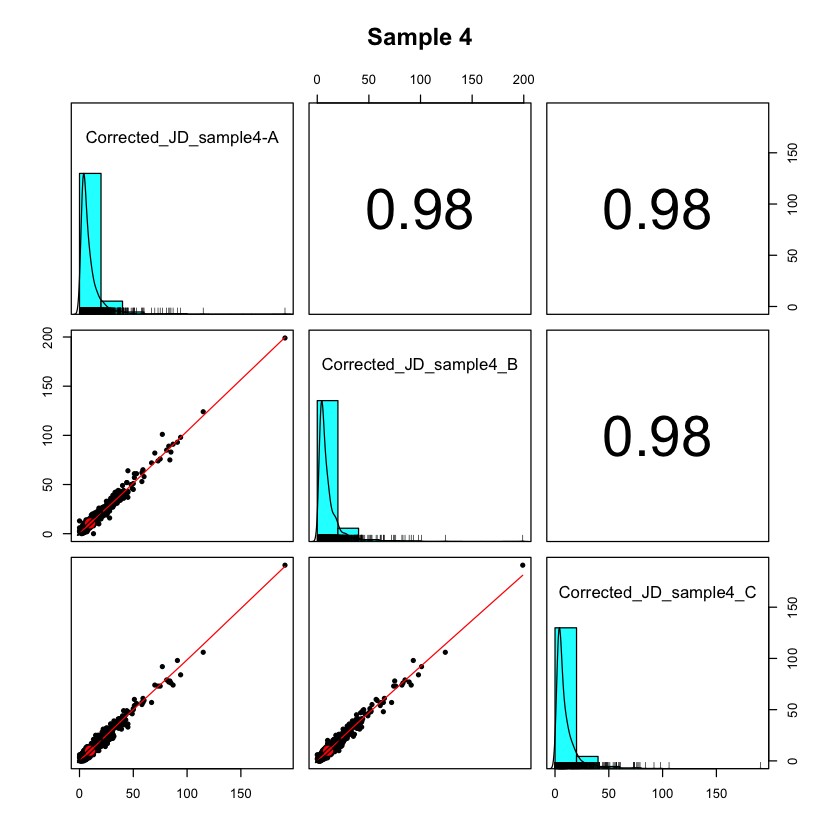

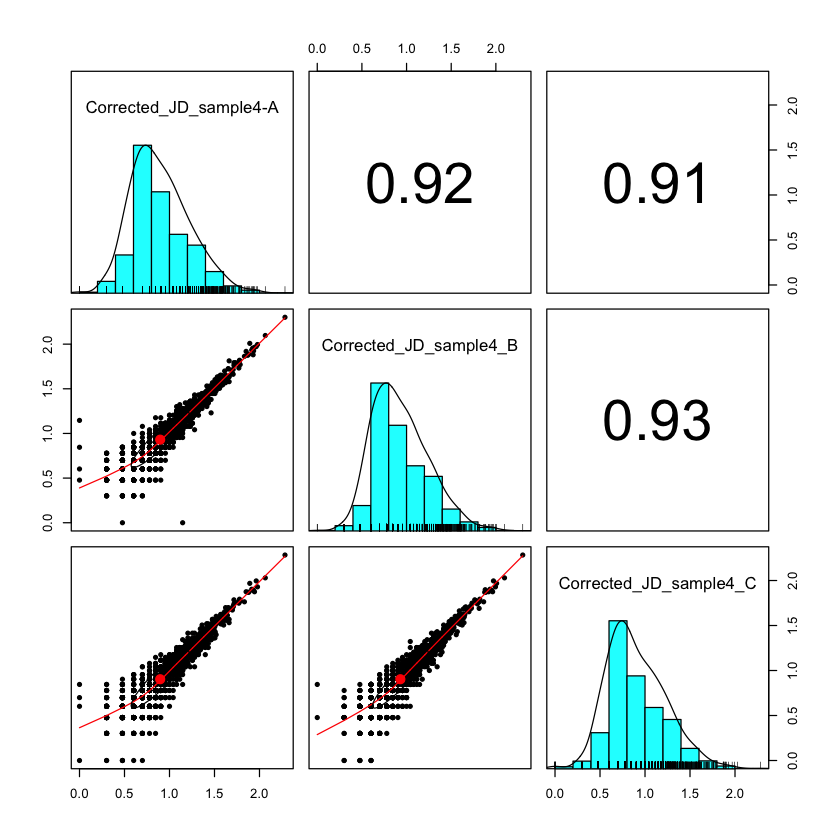

In [7]:
S1 <- 1:3
S2 <- 4:6
S3 <- 7:9
S4 <- 10:12
pairs.panels(counts[S1], main = "Sample 1")
pairs.panels(log10(counts[S1]+1))
pairs.panels(counts[S2], main = "Sample 2")
pairs.panels(log10(counts[S2]+1))
pairs.panels(counts[S3], main = "Sample 3")
pairs.panels(log10(counts[S3]+1))
pairs.panels(counts[S4], main = "Sample 4")
pairs.panels(log10(counts[S4]+1))

## We can get started with edgeR
We will use the counts and accessions that we created in R above from the main summary file and load data into some edgeR data structures. We will run the built-in TMM normalization and see if the samples have any structure in a cluster plot. With only 6 spike-in proteins out of 1742 yeast proteins, there may not be much to drive any sample differences.

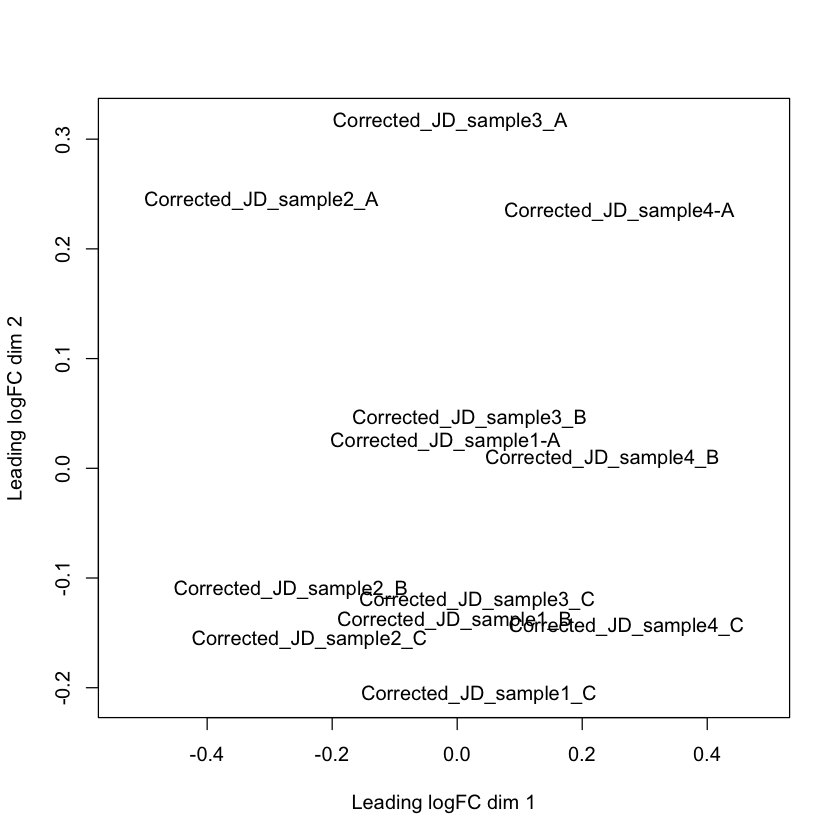

In [8]:
# load the data into edgeR data structures
# group labels need to be factors
group = factor(c(rep(1, 3), rep(2, 3), rep(3, 3), rep(4, 3)))
yglm <- DGEList(counts = counts, group = group, genes = accessions$acc)

# run the TMM normalization (and library size corrections)
yglm <- calcNormFactors(yglm)

# check clustering (6 different out of 1748 may not do much)
plotMDS(yglm)

## Clustering does not show much difference between samples

## How to analyze this data?
Four samples with some protein differences might be a time course or a control group and some different treatments, etc. Something like an ANOVA might be appropriate. EdgeR can do more complicated study designs if we use the linear modeling options. Let's try an ANOVA like test. To do that, we will have to create a model matrix with an intercept term. 

There are other ways to create linear model matrices and this topic is beyond the scope of this notebook. EdgeR and limma user's guides are good places to start. Some R books and statistics books that use R may have useful details on this topic. R blogs and other online content can also help. I am still looking for a good information source on this topic.

In [9]:
# create the experimental design matrix
design <- model.matrix(~group)
rownames(design) <- colnames(yglm)
design

,(Intercept),group2,group3,group4
Corrected_JD_sample1-A,1,0,0,0
Corrected_JD_sample1_B,1,0,0,0
Corrected_JD_sample1_C,1,0,0,0
Corrected_JD_sample2_A,1,1,0,0
Corrected_JD_sample2_B,1,1,0,0
Corrected_JD_sample2_C,1,1,0,0
Corrected_JD_sample3_A,1,0,1,0
Corrected_JD_sample3_B,1,0,1,0
Corrected_JD_sample3_C,1,0,1,0
Corrected_JD_sample4-A,1,0,0,1


In [10]:
# extimate the dispersion parameters and check everything
yglm <- estimateDisp(yglm, design)
# yglm

In [11]:
# fit statistical models (design matrix already in y$design)
fit <- glmQLFit(yglm)

In [12]:
# this tests if any conditions caused differences
any <- glmQLFTest(fit, coef = 2:4)
topTags(any)
summary(decideTests(any))

,genes,logFC.group2,logFC.group3,logFC.group4,logCPM,F,PValue,FDR
14,EXTRA_0005_family,-3.0390968,-0.47789786,2.83148662,11.781901,1662.929975,2.126249e-25,3.716683e-22
25,EXTRA_0003,-4.1860078,1.35195232,1.38307443,11.496992,512.025268,5.359766e-20,4.684435e-17
26,EXTRA_0004,3.8305868,3.66580961,2.61870513,11.494661,410.268862,5.462723e-19,3.182946e-16
388,EXTRA_0006,3.6232488,0.02400975,-1.27174014,9.733695,349.515774,2.912732e-18,1.272864e-15
616,EXTRA_0002,-1.8902071,-7.05135409,0.05582693,9.300353,146.677118,1.864170e-13,6.517139e-11
936,EXTRA_0001,-0.2668561,-2.05322620,-3.79363509,8.802211,46.248122,1.681797e-09,4.899636e-07
1605,sp|P05745|RL36A_YEAST,-1.5567819,-0.37963407,-2.17295834,8.109190,3.443796,3.494937e-02,9.998737e-01
3,sp|P06169|PDC1_YEAST,0.1157441,0.32428102,0.14612389,12.380975,5.712153,5.280332e-02,9.998737e-01
1299,sp|P00546|CDK1_YEAST,-0.2227935,-0.46509852,-1.58431245,8.372229,5.972899,9.033396e-02,9.998737e-01
1109,sp|Q02648|TRM44_YEAST,-0.7376708,-1.16413578,-0.10640011,8.594630,6.481907,1.001249e-01,9.998737e-01


       group4-group3-group2
NotSig                 1742
Sig                       6

## We have only the 6 spiked in proteins as significant
Visualizing multi-condition results like an ANOVA is difficult. Another way to explore this data is to look at samples in pairwise comparisons.

If we wanted to look at pairwise comparisons between the different samples, we would want a design matrix without an intercept term. Then we could explore different contrasts (see edgeR user's guide for much more details). Another option is to use the classic exact test in edgeR. We can get dispersion estimates experiment-wide to make the statistical testing more robust.

## Make new DGEList object for classic testing

Design matrix not provided. Switch to the classic mode.


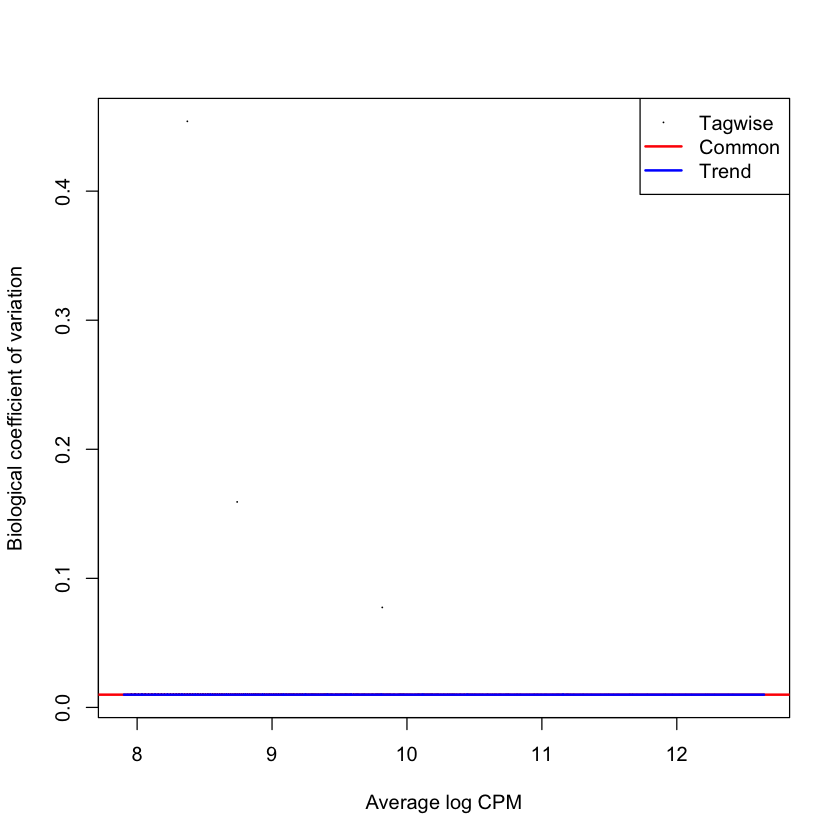

In [13]:
group = c(rep("S1", 3), rep("S2", 3), rep("S3", 3), rep("S4", 3))
yc <- DGEList(counts = counts, group = group, genes = accessions$acc)
yc <- calcNormFactors(yc)
yc <- estimateDisp(yc)
plotBCV(yc)

## Biological variation is flat because of the contant Yeast background 
## We can check TMM normalization and save normalized counts in "results"

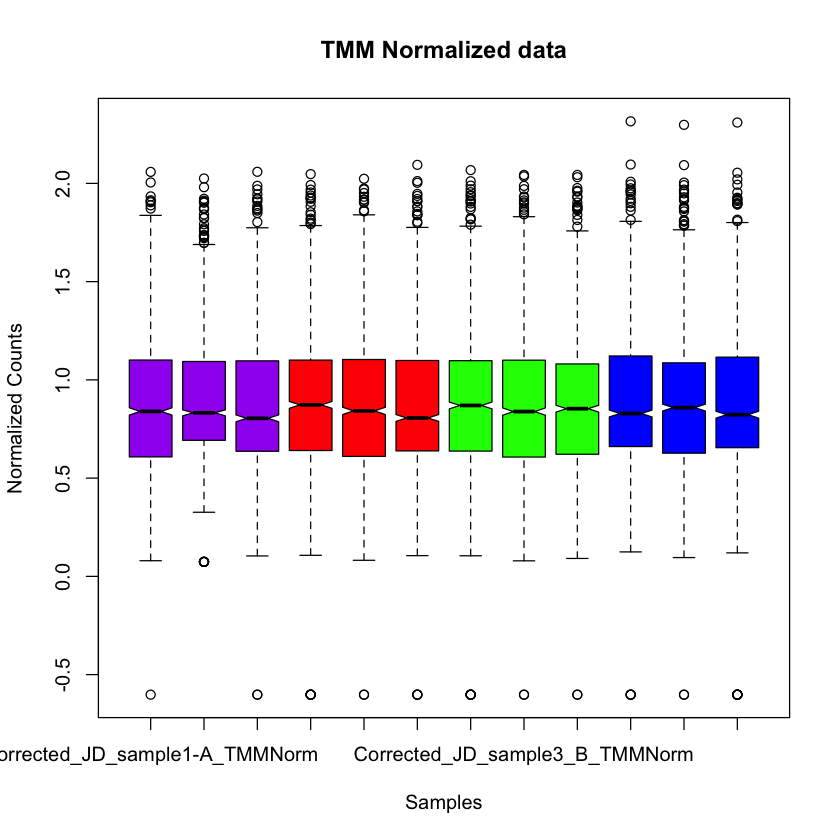

In [14]:
# Compute the normalized counts (start with counts)
# sample loading adjusts each channel to the same average total
lib_facs <- mean(colSums(counts)) / colSums(counts)

# the TMM factors are library adjustment factors (so divide by them)
norm_facs <- lib_facs / yc$samples$norm.factors

# compute the normalized data as a new data frame
counts_norm <- sweep(counts, 2, norm_facs, FUN = "*")
colnames(counts_norm) <- paste(colnames(counts), "TMMNorm", sep = "_")

# add normalized counts to results
results <- cbind(results, counts_norm)

# look at count distributions across samples
boxplot(log10(counts_norm + 0.25), 
        col = c(rep("purple", 3), rep("red", 3), rep("green", 3), rep("blue", 3)),
        xlab = 'Samples', ylab = 'Normalized Counts', 
        main = 'TMM Normalized data', notch = TRUE)

## We can also see what SpC CV distributions are like
The normalization factors in the DGEList object are all pretty close to 1.0 so we may not see much of an effect on the CV distribution before and after normalization. Since there are only a few spike-in proteins, the CVs were computed across all 12 samples (it is mostly the same yeast background).

Raw  Norm 
19.56 19.04

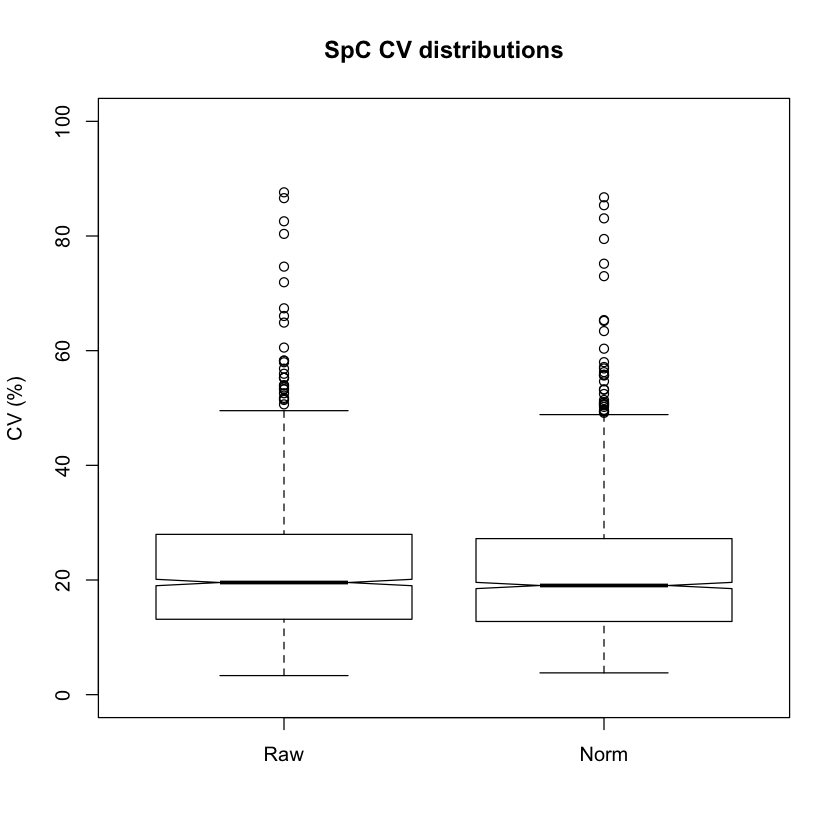

In [15]:
# input: data frame, output: vector of CVs (%)
CV <- function(df) {
  ave <- rowMeans(df)
  sd <- apply(df, 1, sd)
  cv <- 100 * sd / ave
}

# put CVs in a data frame to simplify plots and summaries
cv_frame <- data.frame(Raw = CV(counts), Norm = CV(counts_norm))
medians <- apply(cv_frame, 2, FUN = median)
round(medians, 2)
boxplot(cv_frame, notch = TRUE, main = "SpC CV distributions", ylim = c(0, 100), ylab = "CV (%)")

## Let's run through the 6 comparisons
We will be using the exact test for each pair; however, the variance is estimated experiment-wide. We have the data loaded into "yc", have done TMM normalization, and estimated dispersions. We can specify which pairs we want to compare and compute a modified Fisher's exact test. We will make a table of the spike-in levels for each of the 6 proteins, so we know what to expect. We will print out the test results for the most significant candidates and visualize them with an MA plot. limma has a function to make MA plots easily.

## Sample 1 versus sample 2
Here are the different levels for the spike-in proteins:

|Protein|Sample 1|Sample 2|Direction|
|---|---|---|---|
|EXTRA_0001|65|55|NC|
|EXTRA_0002|55|15|Down|
|EXTRA_0003|15|2|Down|
|EXTRA_0004|2|65|Up|
|EXTRA_0005_family|11|0.6|Down|
|EXTRA_0006|10|500|Up|

We expect **3 Down** and **2 up**.

,genes,logFC,logCPM,PValue,FDR
26,EXTRA_0004,3.8310022,11.494661,1.836966e-55,3.211016e-52
388,EXTRA_0006,3.6239118,9.733695,1.306188e-29,1.141608e-26
25,EXTRA_0003,-4.1874022,11.496992,5.383108e-24,3.136557e-21
14,EXTRA_0005_family,-3.0397680,11.781901,1.875100e-16,8.194189e-14
616,EXTRA_0002,-1.8906399,9.300353,3.049354e-06,1.066054e-03
1605,sp|P05745|RL36A_YEAST,-1.5577561,8.109190,2.662897e-02,1.000000e+00
1259,sp|P24521|ERG8_YEAST,-1.0834506,8.411766,7.558008e-02,1.000000e+00
1377,sp|P41832|BNI1_YEAST,-0.9970355,8.310830,8.723017e-02,1.000000e+00
929,sp|P53893|RIA1_YEAST,-0.7690929,8.817017,1.082407e-01,1.000000e+00
590,sp|P32795|YME1_YEAST,-0.6036097,9.341859,1.239177e-01,1.000000e+00


       S2-S1
Down       3
NotSig  1743
Up         2

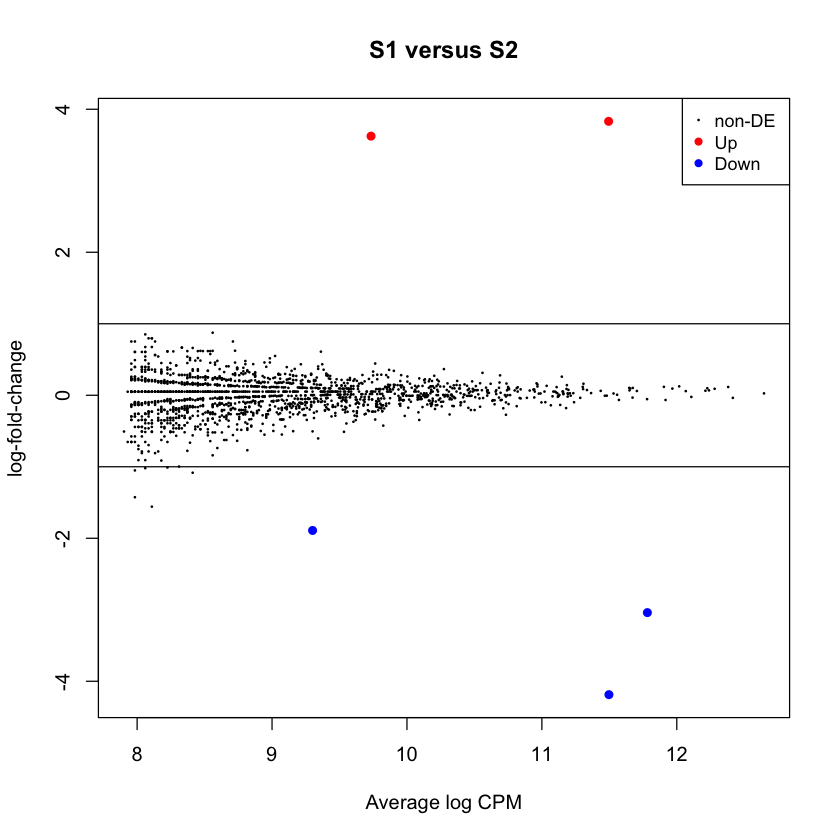

In [16]:
# make average vectors (for results)
S1.ave <- rowMeans(counts_norm[S1])
S2.ave <- rowMeans(counts_norm[S2])

# exact test
et1_2 <- exactTest(yc, pair = c("S1", "S2"))

# look at top DE table, see up and down, and a MA plot
tt <- topTags(et1_2)
tt$table

summary(decideTests(et1_2))
plotMD(et1_2, main = "S1 versus S2")
abline(h = c(-1, 1), col = "black")

## Sample 1 versus sample 3
Here are the different levels for the spike-in proteins:

|Protein|Sample 1|Sample 3|Direction|
|---|---|---|---|
|EXTRA_0001|65|15|Down|
|EXTRA_0002|55|2|Down|
|EXTRA_0003|15|65|Up|
|EXTRA_0004|2|55|Up|
|EXTRA_0005_family|11|10|NC|
|EXTRA_0006|10|11|NC|

We expect **2 Down** and **2 up**.

,genes,logFC,logCPM,PValue,FDR
26,EXTRA_0004,3.6664746,11.494661,7.203621e-48,1.259193e-44
25,EXTRA_0003,1.3520319,11.496992,8.138751e-17,7.113268e-14
616,EXTRA_0002,-7.0857602,9.300353,9.067870e-16,5.283545e-13
936,EXTRA_0001,-2.0544083,8.802211,4.217887e-05,1.843217e-02
3,sp|P06169|PDC1_YEAST,0.3242911,12.380975,8.620170e-03,1.000000e+00
100,sp|P15891|ABP1_YEAST,-0.5081754,10.714065,3.117824e-02,1.000000e+00
13,sp|P33892|GCN1_YEAST,0.2911402,11.904481,4.171051e-02,1.000000e+00
1109,sp|Q02648|TRM44_YEAST,-1.1649063,8.594630,4.282405e-02,1.000000e+00
992,sp|P25847|MSH2_YEAST,-0.9553096,8.741466,5.332695e-02,1.000000e+00
14,EXTRA_0005_family,-0.4779568,11.781901,6.033930e-02,1.000000e+00


       S3-S1
Down       2
NotSig  1744
Up         2

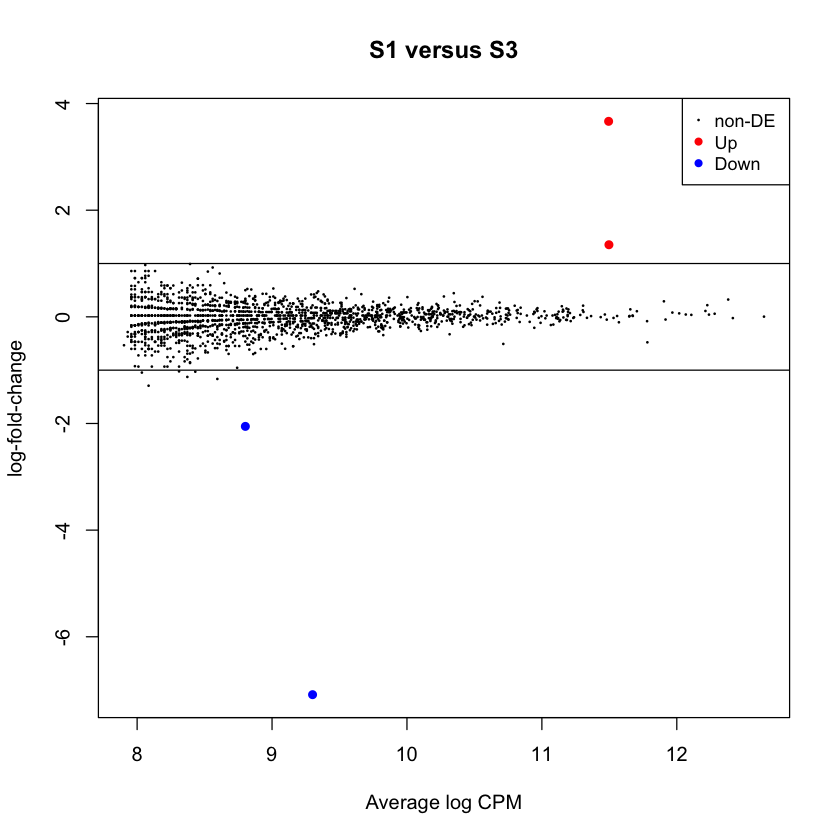

In [17]:
# make average vectors (for results)
S3.ave <- rowMeans(counts_norm[S3])

# exact test
et1_3 <- exactTest(yc, pair = c("S1", "S3"))

# look at top DE table, see up and down, and a MA plot
tt <- topTags(et1_3)
tt$table # this works at Github
summary(decideTests(et1_3))
plotMD(et1_3, main = "S1 versus S3")
abline(h = c(-1, 1), col = "black")

## Sample 1 versus sample 4
Here are the different levels for the spike-in proteins:

|Protein|Sample 1|Sample 4|Direction|
|---|---|---|---|
|EXTRA_0001|65|2|Down|
|EXTRA_0002|55|65|NC|
|EXTRA_0003|15|55|Up|
|EXTRA_0004|2|15|Up|
|EXTRA_0005_family|11|500|Up|
|EXTRA_0006|10|0.6|Down|

We expect **2 Down** and **3 up**.

,genes,logFC,logCPM,PValue,FDR
14,EXTRA_0005_family,2.8314533,11.781901,2.272600e-97,3.972504e-94
25,EXTRA_0003,1.3830536,11.496992,3.398173e-17,2.391187e-14
26,EXTRA_0004,2.6185491,11.494661,4.103867e-17,2.391187e-14
936,EXTRA_0001,-3.7923892,8.802211,1.957007e-08,8.552122e-06
1605,sp|P05745|RL36A_YEAST,-2.1722245,8.109190,7.546204e-03,1.000000e+00
1299,sp|P00546|CDK1_YEAST,-1.5839185,8.372229,2.662897e-02,1.000000e+00
1578,sp|P14065|GCY1_YEAST,-1.5047026,8.060289,4.907249e-02,1.000000e+00
1638,sp|P40341|YTA12_YEAST,-1.6471653,8.060286,5.740089e-02,1.000000e+00
725,sp|P32590|HSP79_YEAST,-0.8704304,9.133040,7.255836e-02,1.000000e+00
1377,sp|P41832|BNI1_YEAST,-1.0997245,8.310830,7.558008e-02,1.000000e+00


       S4-S1
Down       1
NotSig  1744
Up         3

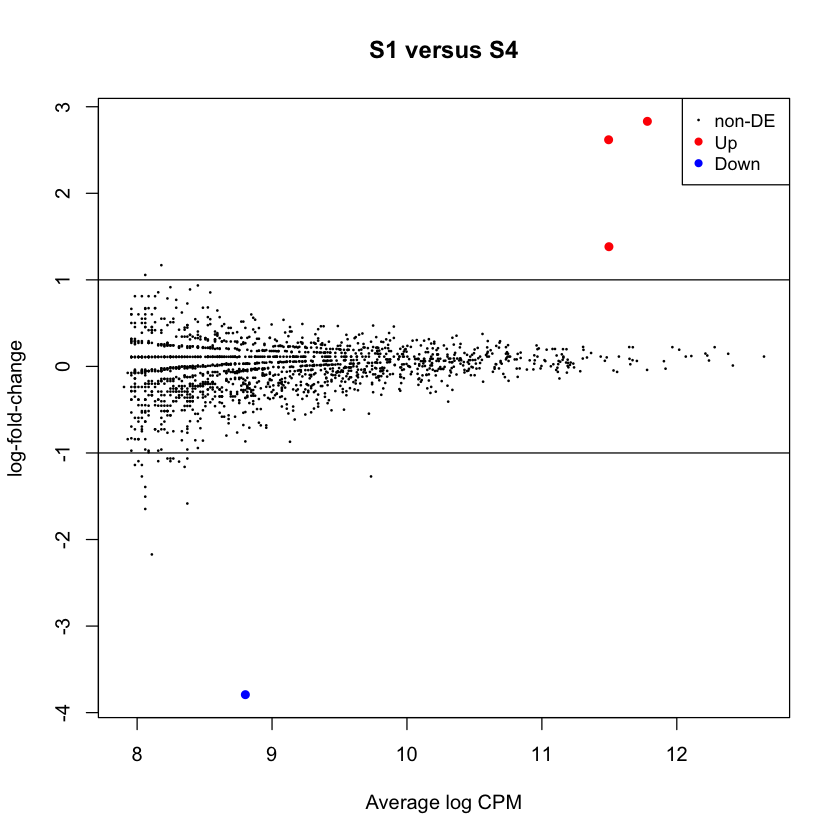

In [18]:
# make average vectors (for results)
S4.ave <- rowMeans(counts_norm[S4])

# exact test
et1_4 <- exactTest(yc, pair = c("S1", "S4"))

# look at top DE table, see up and down, and a MA plot
tt <- topTags(et1_4)
tt$table
summary(decideTests(et1_4))
plotMD(et1_4, main = "S1 versus S4")
abline(h = c(-1, 1), col = "black")

## Sample 2 versus sample 3
Here are the different levels for the spike-in proteins:

|Protein|Sample 2|Sample 3|Direction|
|---|---|---|---|
|EXTRA_0001|55|15|Down|
|EXTRA_0002|15|2|Down|
|EXTRA_0003|2|65|Up|
|EXTRA_0004|65|55|NC|
|EXTRA_0005_family|0.6|10|Up|
|EXTRA_0006|500|11|Down|

We expect **3 Down** and **2 up**.

,genes,logFC,logCPM,PValue,FDR
25,EXTRA_0003,5.5385551,11.496992,1.295192e-67,2.263996e-64
388,EXTRA_0006,-3.5995074,9.733695,1.633848e-28,1.427983e-25
14,EXTRA_0005_family,2.5614605,11.781901,2.748076e-10,1.601212e-07
616,EXTRA_0002,-5.1696704,9.300353,2.444507e-04,1.068250e-01
936,EXTRA_0001,-1.7866521,8.802211,1.197060e-03,4.184921e-01
925,sp|P38069|MNN2_YEAST,1.0069182,8.817019,3.853984e-02,1.000000e+00
3,sp|P06169|PDC1_YEAST,0.2085385,12.380975,8.055646e-02,1.000000e+00
171,sp|P00358|G3P2_YEAST,0.4668037,10.346986,8.515438e-02,1.000000e+00
1690,sp|P32843|YME2_YEAST,1.3531560,7.983669,1.185140e-01,1.000000e+00
1723,sp|P00425|COX5B_YEAST,1.3531459,8.009666,1.185140e-01,1.000000e+00


       S3-S2
Down       1
NotSig  1745
Up         2

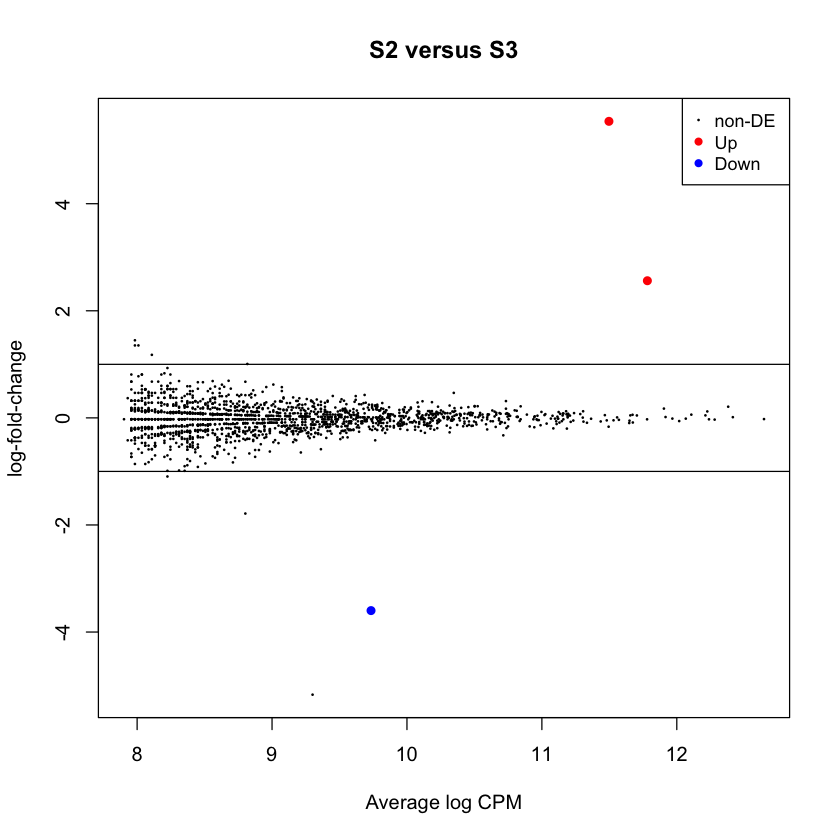

In [19]:
# exact test
et2_3 <- exactTest(yc, pair = c("S2", "S3"))

# look at top DE table, see up and down, and a MA plot
tt <- topTags(et2_3)
tt$table
summary(decideTests(et2_3))
plotMD(et2_3, main = "S2 versus S3")
abline(h = c(-1, 1), col = "black")

## Sample 2 versus sample 4
Here are the different levels for the spike-in proteins:

|Protein|Sample 2|Sample 4|Direction|
|---|---|---|---|
|EXTRA_0001|55|2|Down|
|EXTRA_0002|15|65|Up|
|EXTRA_0003|2|55|Up|
|EXTRA_0004|65|15|Down|
|EXTRA_0005_family|0.6|500|Up|
|EXTRA_0006|500|0.6|Down|

We expect **3 Down** and **3 up**.

,genes,logFC,logCPM,PValue,FDR
14,EXTRA_0005_family,5.8693105,11.781901,1.154323e-161,2.017757e-158
25,EXTRA_0003,5.5666360,11.496992,7.450875e-68,6.512065e-65
388,EXTRA_0006,-4.8921373,9.733695,2.636507e-33,1.536205e-30
26,EXTRA_0004,-1.2118115,11.494661,8.288717e-14,3.622169e-11
936,EXTRA_0001,-3.5218035,8.802211,8.726184e-07,3.050674e-04
616,EXTRA_0002,1.9452902,9.300353,3.049354e-06,8.883785e-04
98,sp|P02829|HSP82_YEAST,0.4951033,10.733706,3.017401e-02,1.000000e+00
1444,sp|Q06488|RSC2_YEAST,-1.4570233,8.246700,4.142196e-02,1.000000e+00
1422,sp|P51401|RL9B_YEAST,1.4206181,8.246710,5.252049e-02,1.000000e+00
1298,sp|P12684|HMDH2_YEAST,-1.3013975,8.372230,5.252049e-02,1.000000e+00


       S4-S2
Down       3
NotSig  1742
Up         3

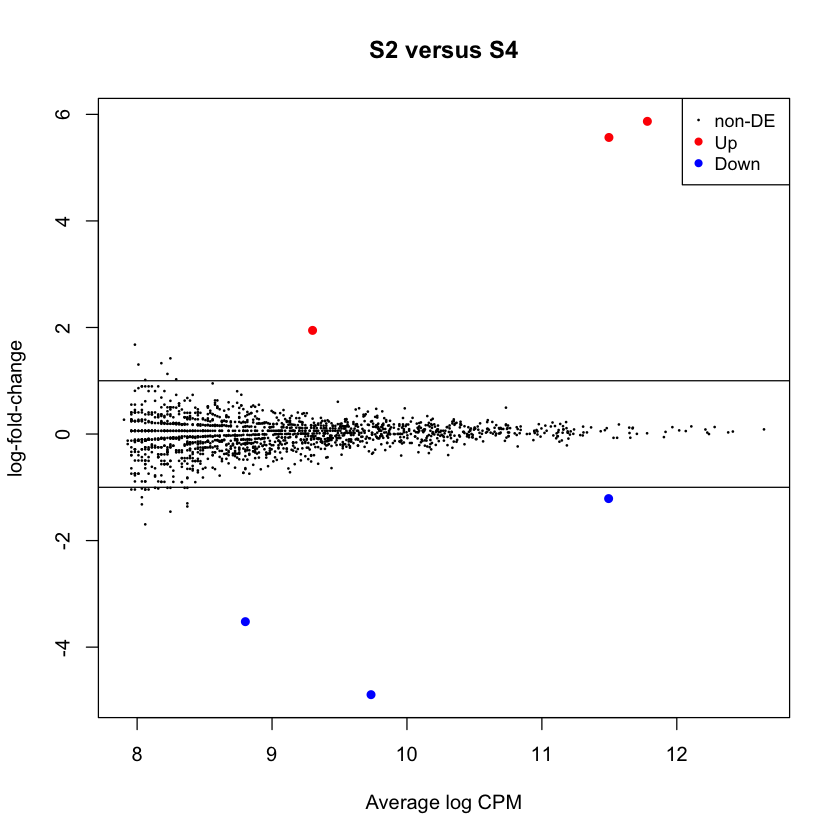

In [20]:
# exact test
et2_4 <- exactTest(yc, pair = c("S2", "S4"))

# look at top DE table, see up and down, and a MA plot
tt <- topTags(et2_4)
tt$table
summary(decideTests(et2_4))
plotMD(et2_4, main = "S2 versus S4")
abline(h = c(-1, 1), col = "black")

## Sample 3 versus sample 4
Here are the different levels for the spike-in proteins:

|Protein|Sample 3|Sample 4|Direction|
|---|---|---|---|
|EXTRA_0001|15|2|Down|
|EXTRA_0002|2|65|Up|
|EXTRA_0003|65|55|NC|
|EXTRA_0004|55|15|Down|
|EXTRA_0005_family|10|500|Up|
|EXTRA_0006|11|0.6|Down|

We expect **3 Down** and **2 up**.

,genes,logFC,logCPM,PValue,FDR
14,EXTRA_0005_family,3.3092646,11.781901,1.123623e-112,1.964092e-109
616,EXTRA_0002,7.0856577,9.300353,1.812100e-15,1.583776e-12
26,EXTRA_0004,-1.0470658,11.494661,2.746190e-10,1.600113e-07
1605,sp|P05745|RL36A_YEAST,-1.7916689,8.109190,3.517795e-02,1.000000e+00
1584,sp|P25558|BUD3_YEAST,-1.5281419,8.084948,4.907249e-02,1.000000e+00
1320,sp|Q06385|VPS74_YEAST,-1.2755223,8.372233,5.252049e-02,1.000000e+00
1385,sp|Q12511|PDP1_YEAST,1.3555045,8.310838,7.840442e-02,1.000000e+00
100,sp|P15891|ABP1_YEAST,0.4214907,10.714065,7.917369e-02,1.000000e+00
1212,sp|P01119|RAS1_YEAST,-1.0649581,8.431127,9.320053e-02,1.000000e+00
1101,sp|P12904|AAKG_YEAST,0.8551228,8.594626,9.881912e-02,1.000000e+00


       S4-S3
Down       1
NotSig  1745
Up         2

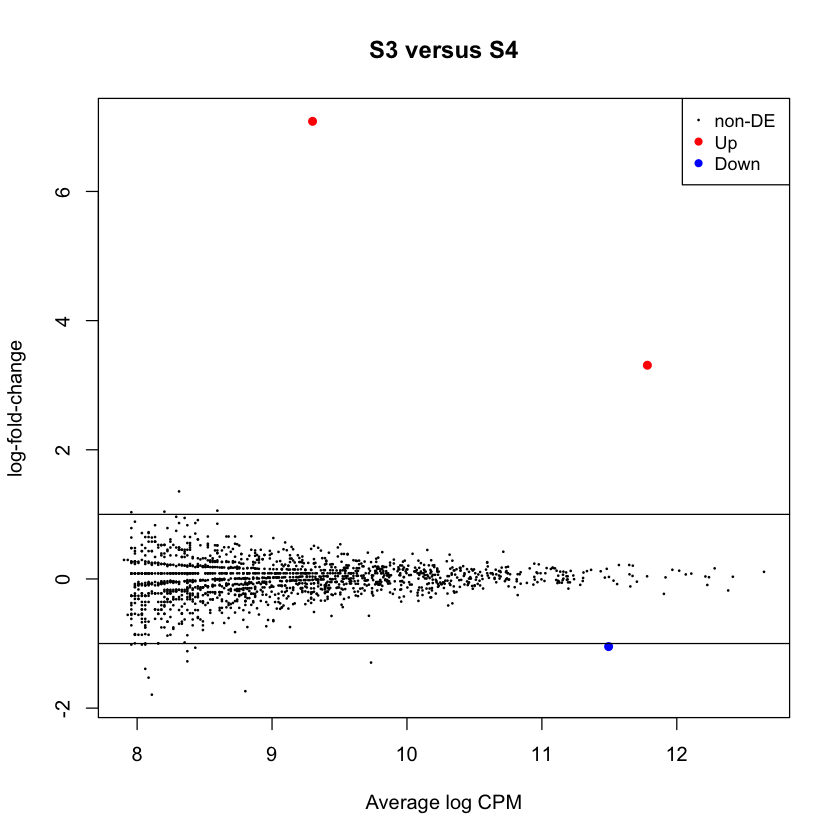

In [21]:
# exact test
et3_4 <- exactTest(yc, pair = c("S3", "S4"))

# look at top DE table, see up and down, and a MA plot
tt <- topTags(et3_4)
tt$table
summary(decideTests(et3_4))
plotMD(et3_4, main = "S3 versus S4")
abline(h = c(-1, 1), col = "black")

## Results are pretty good
We do not have any false positive yeast proteins; only the spike-in proteins are significant DE candidates. We do not recover 100% of the spike-in results, though. Some of the lower abundance spike-in proteins are missing. Not all proteins have the same detectability in shotgun studies even if they are at similar concentrations.

Spectral counts are not too linear with protein concentration. Highly abundant proteins are under counted and low abundance proteins are over counted. The response is more sigmodal. Testing measured fold changes against known fold changes is not as important as making good DE calls.

I used the plotMD function from limma to visualize candidates. The ggplot2 package can also be used (I have done so in other notebooks), but this data has few DE candidates, so I will not do any additional DE candidate visualizations here (scatter plots, MA plots, or volcano plots). Another QC plot that is very useful is the distribution of uncorrected p-values from the statistical test(s). We have so few candidates so this will also be skipped.

## Get the test results added to the "results" data frame
We need a robust final table that has our protein identification details **and** the quantitative analysis results together in a nice way. For each test we will have the average count vectors and the p-values table.

In [22]:
# make a little frame for each pairwise test
df1_2 <- data.frame(S1.ave, S2.ave, topTags(et1_2, n = Inf, sort.by = "none"))
colnames(df1_2) <- paste(colnames(df1_2), "1vs2", sep = ".")

df1_3 <- data.frame(S1.ave, S3.ave, topTags(et1_3, n = Inf, sort.by = "none"))
colnames(df1_3) <- paste(colnames(df1_3), "1vs3", sep = ".")

df1_4 <- data.frame(S1.ave, S4.ave, topTags(et1_4, n = Inf, sort.by = "none"))
colnames(df1_4) <- paste(colnames(df1_4), "1vs4", sep = ".")

df2_3 <- data.frame(S2.ave, S3.ave, topTags(et2_3, n = Inf, sort.by = "none"))
colnames(df2_3) <- paste(colnames(df2_3), "2vs3", sep = ".")

df2_4 <- data.frame(S2.ave, S4.ave, topTags(et2_4, n = Inf, sort.by = "none"))
colnames(df2_4) <- paste(colnames(df2_4), "2vs4", sep = ".")

df3_4 <- data.frame(S3.ave, S4.ave, topTags(et3_4, n = Inf, sort.by = "none"))
colnames(df3_4) <- paste(colnames(df3_4), "3vs4", sep = ".")

# add to results
results <- cbind(results, df1_2, df1_3, df1_4, df2_3, df2_4, df3_4)

# drop the original count data from results (duplicated columns are issue with merging)
colnames(results)

[1] "acc"                            "Corrected_JD_sample1-A_TMMNorm"
 [3] "Corrected_JD_sample1_B_TMMNorm" "Corrected_JD_sample1_C_TMMNorm"
 [5] "Corrected_JD_sample2_A_TMMNorm" "Corrected_JD_sample2_B_TMMNorm"
 [7] "Corrected_JD_sample2_C_TMMNorm" "Corrected_JD_sample3_A_TMMNorm"
 [9] "Corrected_JD_sample3_B_TMMNorm" "Corrected_JD_sample3_C_TMMNorm"
[11] "Corrected_JD_sample4-A_TMMNorm" "Corrected_JD_sample4_B_TMMNorm"
[13] "Corrected_JD_sample4_C_TMMNorm" "S1.ave.1vs2"                   
[15] "S2.ave.1vs2"                    "genes.1vs2"                    
[17] "logFC.1vs2"                     "logCPM.1vs2"                   
[19] "PValue.1vs2"                    "FDR.1vs2"                      
[21] "S1.ave.1vs3"                    "S3.ave.1vs3"                   
[23] "genes.1vs3"                     "logFC.1vs3"                    
[25] "logCPM.1vs3"                    "PValue.1vs3"                   
[27] "FDR.1vs3"                       "S1.ave.1vs4"                   
[29] "S4.ave.1vs4"                    "genes.1vs4"                    
[31] "logFC.1vs4"                     "logCPM.1vs4"                   
[33] "PValue.1vs4"                    "FDR.1vs4"                      
[35] "S2.ave.2vs3"                    "S3.ave.2vs3"                   
[37] "genes.2vs3"                     "logFC.2vs3"                    
[39] "logCPM.2vs3"                    "PValue.2vs3"                   
[41] "FDR.2vs3"                       "S2.ave.2vs4"                   
[43] "S4.ave.2vs4"                    "genes.2vs4"                    
[45] "logFC.2vs4"                     "logCPM.2vs4"                   
[47] "PValue.2vs4"                    "FDR.2vs4"                      
[49] "S3.ave.3vs4"                    "S4.ave.3vs4"                   
[51] "genes.3vs4"                     "logFC.3vs4"                    
[53] "logCPM.3vs4"                    "PValue.3vs4"                   
[55] "FDR.3vs4"

In [23]:
# table "full" has more rows than "results", so we want a left join merge
full_with_stats <- left_join(full, results, by = "acc")
colnames(full_with_stats)

[1] "ProtGroup"                      "Counter"                       
  [3] "Accession"                      "Identical"                     
  [5] "Similar"                        "OtherLoci"                     
  [7] "Filter"                         "Coverage"                      
  [9] "SeqLength"                      "MW"                            
 [11] "Description"                    "CountsTot"                     
 [13] "UniqueTot"                      "UniqFrac"                      
 [15] "Total_JD_sample1-A"             "Total_JD_sample1_B"            
 [17] "Total_JD_sample1_C"             "Total_JD_sample2_A"            
 [19] "Total_JD_sample2_B"             "Total_JD_sample2_C"            
 [21] "Total_JD_sample3_A"             "Total_JD_sample3_B"            
 [23] "Total_JD_sample3_C"             "Total_JD_sample4-A"            
 [25] "Total_JD_sample4_B"             "Total_JD_sample4_C"            
 [27] "Unique_JD_sample1-A"            "Unique_JD_sample1_B"           
 [29] "Unique_JD_sample1_C"            "Unique_JD_sample2_A"           
 [31] "Unique_JD_sample2_B"            "Unique_JD_sample2_C"           
 [33] "Unique_JD_sample3_A"            "Unique_JD_sample3_B"           
 [35] "Unique_JD_sample3_C"            "Unique_JD_sample4-A"           
 [37] "Unique_JD_sample4_B"            "Unique_JD_sample4_C"           
 [39] "Corrected_JD_sample1-A"         "Corrected_JD_sample1_B"        
 [41] "Corrected_JD_sample1_C"         "Corrected_JD_sample2_A"        
 [43] "Corrected_JD_sample2_B"         "Corrected_JD_sample2_C"        
 [45] "Corrected_JD_sample3_A"         "Corrected_JD_sample3_B"        
 [47] "Corrected_JD_sample3_C"         "Corrected_JD_sample4-A"        
 [49] "Corrected_JD_sample4_B"         "Corrected_JD_sample4_C"        
 [51] "acc"                            "ave"                           
 [53] "missing"                        "Corrected_JD_sample1-A_TMMNorm"
 [55] "Corrected_JD_sample1_B_TMMNorm" "Corrected_JD_sample1_C_TMMNorm"
 [57] "Corrected_JD_sample2_A_TMMNorm" "Corrected_JD_sample2_B_TMMNorm"
 [59] "Corrected_JD_sample2_C_TMMNorm" "Corrected_JD_sample3_A_TMMNorm"
 [61] "Corrected_JD_sample3_B_TMMNorm" "Corrected_JD_sample3_C_TMMNorm"
 [63] "Corrected_JD_sample4-A_TMMNorm" "Corrected_JD_sample4_B_TMMNorm"
 [65] "Corrected_JD_sample4_C_TMMNorm" "S1.ave.1vs2"                   
 [67] "S2.ave.1vs2"                    "genes.1vs2"                    
 [69] "logFC.1vs2"                     "logCPM.1vs2"                   
 [71] "PValue.1vs2"                    "FDR.1vs2"                      
 [73] "S1.ave.1vs3"                    "S3.ave.1vs3"                   
 [75] "genes.1vs3"                     "logFC.1vs3"                    
 [77] "logCPM.1vs3"                    "PValue.1vs3"                   
 [79] "FDR.1vs3"                       "S1.ave.1vs4"                   
 [81] "S4.ave.1vs4"                    "genes.1vs4"                    
 [83] "logFC.1vs4"                     "logCPM.1vs4"                   
 [85] "PValue.1vs4"                    "FDR.1vs4"                      
 [87] "S2.ave.2vs3"                    "S3.ave.2vs3"                   
 [89] "genes.2vs3"                     "logFC.2vs3"                    
 [91] "logCPM.2vs3"                    "PValue.2vs3"                   
 [93] "FDR.2vs3"                       "S2.ave.2vs4"                   
 [95] "S4.ave.2vs4"                    "genes.2vs4"                    
 [97] "logFC.2vs4"                     "logCPM.2vs4"                   
 [99] "PValue.2vs4"                    "FDR.2vs4"                      
[101] "S3.ave.3vs4"                    "S4.ave.3vs4"                   
[103] "genes.3vs4"                     "logFC.3vs4"                    
[105] "logCPM.3vs4"                    "PValue.3vs4"                   
[107] "FDR.3vs4"

## It looks like we have the results table merged correctly
Save it as a new table. And log the session.

In [24]:
write.table(full_with_stats, "PAW_grouped_proteins_with_stats.txt", sep = "\t", row.names = FALSE, na = " ")
sessionInfo()

R version 3.5.0 (2018-04-23)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.14.3

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] bindrcpp_0.2.2     RColorBrewer_1.1-2 psych_1.8.12       forcats_0.3.0     
 [5] stringr_1.3.1      dplyr_0.7.8        purrr_0.3.0        readr_1.3.1       
 [9] tidyr_0.8.2        tibble_2.0.1       ggplot2_3.1.0      tidyverse_1.2.1   
[13] edgeR_3.24.3       limma_3.38.3      

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3     tidyselect_0.2.5 locfit_1.5-9.1   repr_0.19.1     
 [5] splines_3.5.0    haven_2.0.0      lattice_0.20-38  colorspace_1.4-0
 [9] generics_0.0.2   htmlto